There are three different parts of this notebook.

The first part of this notebook shows the differences between computing samples with a normal method and with multiprocessing.

The second part finds the best configuration for the cores.

The third part part of this notebook shows the differences between computing samples with multiprocessing and multithreading.

The first and third part of this note book are very similar to the multithreading notebook.

**Define the functions** 

In [ ]:
import qmcpy as qp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cProfile
import pstats
#Used to store some result computations for comparison.
import pickle

**Define functions**

We use a seed to keep make the results more reproducible. We can also manually change the number of cores the multiprocessing functions use. When this is set to none the library will automatically configure for itself.

In [83]:
num_cores = None
test_seed = 24
def natural(n, points, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,thread=False)
    points = l.gen_samples(points) 
    return points
def linear(n, points, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,thread=False)
    points = l.gen_samples(points) 
    return points
def mps(n, points, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,thread=False)
    points = l.gen_samples(points) 
    return points
def natural_process(n, points, seed=None, cores = None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,process=True,max_workers=cores)
    points = l.gen_samples(points) 
    return points
def linear_process(n, points, seed=None, cores = None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,process=True,max_workers=cores)
    points = l.gen_samples(points) 
    return points
def mps_process(n, points, seed=None, cores = None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,process=True,max_workers=cores)
    points = l.gen_samples(points) 
    return points


**Part 1 comparison between normal computation and multiprocessing**

**Having fixed sample points (2^n) with variable dimension**

In [84]:
trials = 5
dimension_list = [50, 100, 200, 500, 1400, 3500]
n = 10
data = {'Dimensions':dimension_list}
dimension_frame = pd.DataFrame(data)
dimension_frame = dimension_frame.set_index('Dimensions')
names = set()


run_list = [(natural, "natural"),(linear, "linear"),(mps,"mps"),(natural_process, "natural process"),(linear_process,"linear process"),(mps_process, "mps process")]

for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in dimension_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(d, 2 ** n, seed=test_seed)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        times.append(process_time)
        
    dimension_frame[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)  


# Uncomment to view the dimension frame
#print(dimension_frame)
 


             natural    linear       mps  natural process  linear process  \
Dimensions                                                                  
50          0.051227  0.016480  0.016803         0.035257        0.016105   
100         0.042049  0.029167  0.030702         0.040942        0.029791   
200         0.070093  0.061593  0.061324         0.067900        0.065630   
500         0.158957  0.147481  0.152831         0.138037        0.148642   
1400        0.419974  0.407736  0.424929         0.340268        0.401291   
3500        1.040077  1.001907  1.057890         0.819626        1.000849   

            mps process  
Dimensions               
50             0.060948  
100            0.068620  
200            0.090577  
500            0.147323  
1400           0.350686  
3500           0.754289  


In [85]:
comparison= [('mps', 'mps process'), ('linear', 'linear process'), ('natural', 'natural process')]

def speed_up_cal(data_frame, compare_list, column_list):
    result = []
    for seq,pro in compare_list:
        result = []
        for x in column_list:
            a = data_frame[seq][x]
            b = data_frame[pro][x]
            result.append(a/b)
        data_frame[seq + " speed-up"] = result


speed_up_cal(dimension_frame, comparison, dimension_list)

#To view the frame uncomment
#print(dimension_frame)

             natural    linear       mps  natural process  linear process  \
Dimensions                                                                  
50          0.051227  0.016480  0.016803         0.035257        0.016105   
100         0.042049  0.029167  0.030702         0.040942        0.029791   
200         0.070093  0.061593  0.061324         0.067900        0.065630   
500         0.158957  0.147481  0.152831         0.138037        0.148642   
1400        0.419974  0.407736  0.424929         0.340268        0.401291   
3500        1.040077  1.001907  1.057890         0.819626        1.000849   

            mps process  mps speed-up  linear speed-up  natural speed-up  
Dimensions                                                                
50             0.060948      0.275687         1.023278          1.452981  
100            0.068620      0.447424         0.979077          1.027035  
200            0.090577      0.677034         0.938489          1.032298  
500     

**Viewing the results for a constant point number and variable dimensions.**

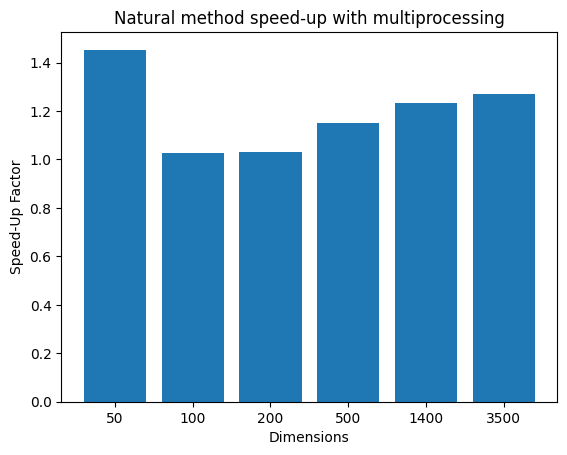

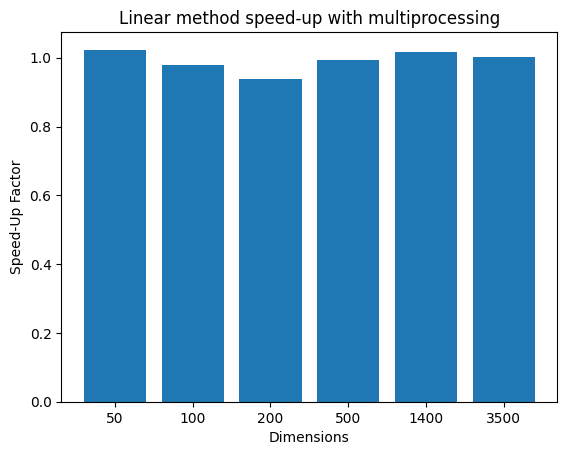

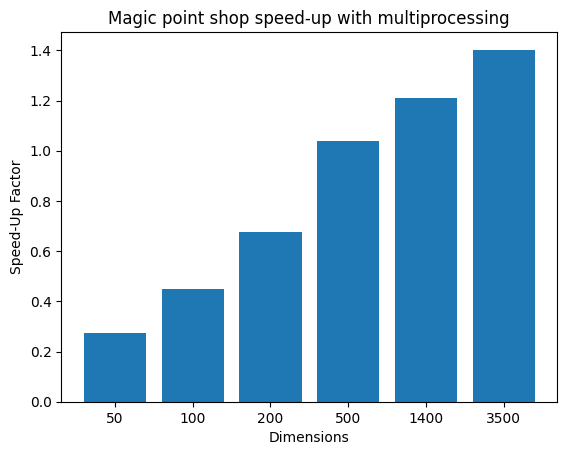

In [86]:
to_str_list = lambda array: [str(x) for x in array]

y_axis = dimension_frame["natural speed-up"].to_numpy()
x_axis = to_str_list(dimension_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Natural method speed-up with multiprocessing')
plt.show()

y_axis = dimension_frame["linear speed-up"].to_numpy()
x_axis = to_str_list(dimension_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Linear method speed-up with multiprocessing')
plt.show()

y_axis = dimension_frame["mps speed-up"].to_numpy()
x_axis = to_str_list(dimension_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Dimensions')
plt.ylabel('Speed-Up Factor')
plt.title('Magic point shop speed-up with multiprocessing')
plt.show()


Having a constant number of dimensions (2^d) and variable number of points.

In [87]:
d = 10
points_list = [10, 100, 1000, 10_000, 15_000]
records = {'Points':points_list}
points_frame = pd.DataFrame(records)
points_frame = points_frame.set_index('Points')


for method, method_name in run_list:
    name = method_name.split(" ")

    names.add(name[0])


    times = []
    
    for p in points_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            method(2 ** d, p, seed=test_seed)
        profiler.disable()
    
        stats = pstats.Stats(profiler)
        
        process_time = stats.total_tt


        times.append(process_time)
    
    points_frame[method_name] = times  
stats.sort_stats('cumulative')


names = list(names)     

#Speed up calculation
speed_up_cal(points_frame, comparison, points_list)

#Uncomment to view updated frame
#print(points_frame)

         natural    linear       mps  natural process  linear process  \
Points                                                                  
10      0.009008  0.007390  0.006910         0.012484        0.007209   
100     0.040404  0.039129  0.035257         0.041287        0.039498   
1000    0.304144  0.296183  0.309663         0.254630        0.295516   
10000   3.889970  4.697845  4.151991         2.830993        4.719417   
15000   4.620415  4.763251  4.816879         3.545962        4.668806   

        mps process  mps speed-up  linear speed-up  natural speed-up  
Points                                                                
10         0.011947      0.578348         1.025080          0.721601  
100        0.038715      0.910695         0.990653          0.978613  
1000       0.272999      1.134301         1.002258          1.194453  
10000      3.419543      1.214195         0.995429          1.374066  
15000      4.019351      1.198422         1.020229          1.

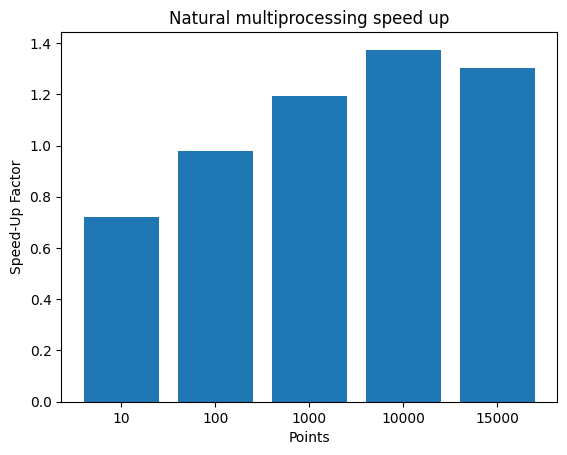

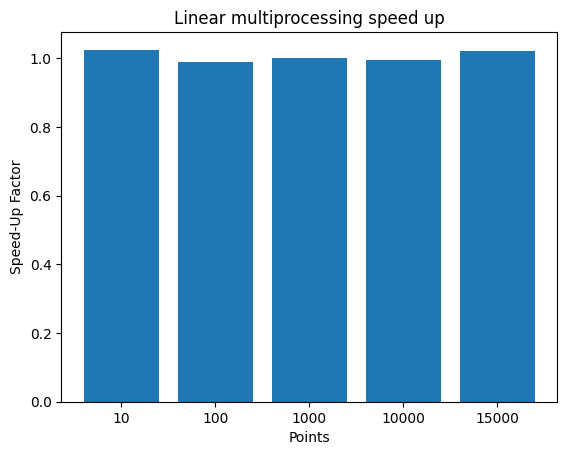

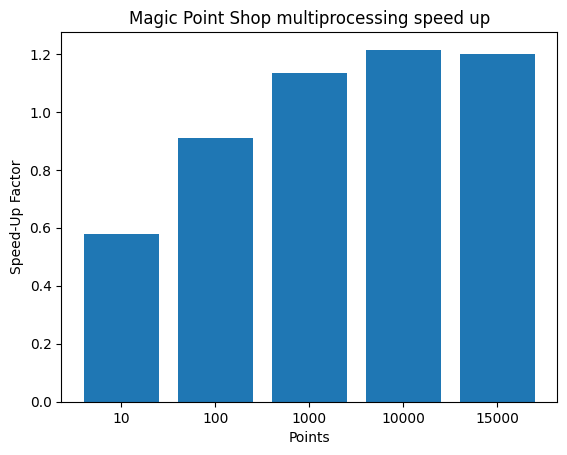

In [88]:


y_axis = points_frame["natural speed-up"].to_numpy()
x_axis = to_str_list(points_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Natural multiprocessing speed up')
plt.show()

y_axis = points_frame["linear speed-up"].to_numpy()
x_axis = to_str_list(points_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Linear multiprocessing speed up')
plt.show()

y_axis = points_frame["mps speed-up"].to_numpy()
x_axis = to_str_list(points_list)
plt.bar(x_axis, y_axis)
plt.xlabel('Points')
plt.ylabel('Speed-Up Factor')
plt.title('Magic Point Shop multiprocessing speed up')
plt.show()

In [89]:

def add_to_file(data, file_path):
    with open(file_path, 'ab') as file:
        pickle.dump(data, file)

def view_file(file_path):
    loaded_objects = []
    with open(file_path, 'rb') as file:
        while True:
            try:
                # Load and append the deserialized object to the list
                obj = pickle.load(file)
                loaded_objects.append(obj)
            except EOFError:
                # Reached the end of the file (EOFError is raised when no more data is available)
                break
    return loaded_objects
    
def clear_file(file_path):
    with open(file_path, 'wb') as file:
        file.truncate(0)

def remove_last_object(file_name):
    objects = view_file(file_name)
    objects.pop()
    clear_file(file_name)
    for i in objects:
        add_to_file(i,file_name)



In [90]:

file_name = "points.pkl"
dimension_speed_up = dimension_frame[["mps speed-up", "linear speed-up", "natural speed-up"]]

point_speed_up = points_frame[["mps speed-up", "linear speed-up", "natural speed-up"]]

to_str_list = [cores, dimension_speed_up, point_speed_up]


# add_to_file(x,file_name)


In [91]:
y = view_file(file_name)
print(y)


[[1,             mps speed-up  linear speed-up  natural speed-up
Dimensions                                                 
50              0.282170         1.030238          0.892335
100             0.474787         0.974009          0.972864
200             0.699696         1.012319          1.048477
500             1.014064         1.007420          1.222627
1400            1.138757         0.981785          1.252160
3500            1.377480         0.995286          1.289300,         mps speed-up  linear speed-up  natural speed-up
Points                                                 
10          0.709929         0.963061          0.719998
100         0.933402         1.033432          1.089045
1000        1.136069         1.023944          1.279503
10000       1.150755         1.021474          1.411189
15000       1.076204         1.024502          1.352890], [2,             mps speed-up  linear speed-up  natural speed-up
Dimensions                                              

In [92]:
vals = []
for i in y: 
    d = i[1]
    c = i[0]
    to_str_list = sum(d["mps speed-up"].tolist()) + sum(d["natural speed-up"].tolist()) + sum(d["linear speed-up"].tolist()) 
    vals.append((c, to_str_list))
print(vals)




[(1, 17.665774891551283), (2, 18.36613143997642), (3, 18.217143733576865), (4, 17.95462448831131), (5, 17.90492680688258), (None, 17.743014685558173)]


**Part 3**